In [1]:
! pip install beautifulsoup4==4.9.1 --quiet
! pip install text-hammer --quiet
! pip install keras_core --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-08-01 22:11:44.998794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 22:11:44.998890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 22:11:45.115615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
TensorFlow version: 2.15.0
KerasNLP version: 0.14.0


In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
from tqdm import tqdm
import text_hammer as th
tqdm.pandas()

def preprocess_tweets(df, text_column):
    
    # Lowercase the text
    df[text_column] = df[text_column].progress_apply(lambda x: str(x).lower())
    
    # Remove emails
    df[text_column] = df[text_column].progress_apply(lambda x: th.remove_emails(x))
    
    # Remove HTML tags
    df[text_column] = df[text_column].progress_apply(lambda x: th.remove_html_tags(x))
    
    # Remove special characters
    df[text_column] = df[text_column].progress_apply(lambda x: th.remove_special_chars(x))
    
    # Remove accented characters
    df[text_column] = df[text_column].progress_apply(lambda x: th.remove_accented_chars(x))
    
    
    return df

In [5]:
df_train = preprocess_tweets(df_train, "text")
df_test = preprocess_tweets(df_test, "text")

df_train.head()

100%|██████████| 3263/3263 [00:00<00:00, 281947.51it/s]


,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
# nltk.download('vader_lexicon')

def sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_train['sentiment'] = df_train['text'].apply(sentiment)
df_test['sentiment'] = df_test['text'].apply(sentiment)

In [7]:
# Ensure all columns are strings before concatenation
df_train["text"] = df_train["text"].astype(str) + " " + df_train["keyword"].astype(str) + " " + df_train["sentiment"].astype(str)

# Display the updated 'text' column
df_train["text"].head()


0    our deeds are the reason of this earthquake ma...
1    forest fire near la ronge sask canada nan nega...
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [8]:
# Ensure all columns are strings before concatenation
df_test["text"] = df_test["text"].astype(str) + " " + df_test["keyword"].astype(str) + " " + df_test["sentiment"].astype(str)

# Display the updated 'text' column
df_test["text"].head()

0      just happened a terrible car crash nan negative
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3    apocalypse lighting spokane wildfires nan neutral
4    typhoon soudelor kills 28 in china and taiwan ...
Name: text, dtype: object

In [9]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      111.927361
std        32.397660
min        18.000000
25%        89.000000
50%       117.000000
75%       141.000000
max       169.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      113.065584
std        32.500040
min        19.000000
25%        91.000000
50%       120.000000
75%       142.000000
max       171.000000
Name: length, dtype: float64


In [10]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [12]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Attaching 'model.safetensors' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook.

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import keras
from keras.optimizers import Adam

# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # 'binary_crossentropy',
    optimizer=Adam(1e-5),  # Ensure correct instantiation
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/2


I0000 00:00:1722550492.737252      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722550492.785161      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7490 - loss: 0.5572

W0000 00:00:1722550598.873966      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722550602.526517      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 179s 617ms/step - accuracy: 0.7492 - loss: 0.5569 - val_accuracy: 0.8359 - val_loss: 0.3980
Epoch 2/2


W0000 00:00:1722550610.297635      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 80s 418ms/step - accuracy: 0.8439 - loss: 0.3821 - val_accuracy: 0.8404 - val_loss: 0.3905


In [14]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

  2/191 ━━━━━━━━━━━━━━━━━━━━ 32s 172ms/step

W0000 00:00:1722550693.761667      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step


W0000 00:00:1722550719.809433      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


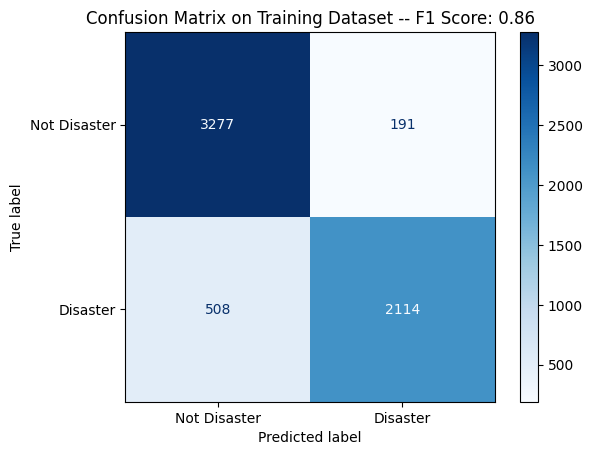

In [15]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step


W0000 00:00:1722550728.609090      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


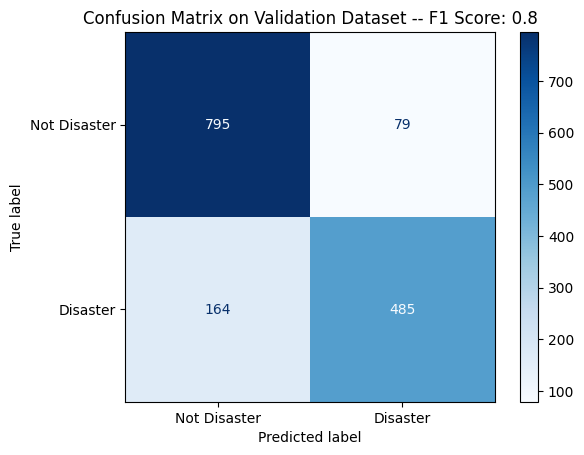

In [16]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [17]:
# get predictions
y_pred = classifier.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step


In [18]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [19]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step


In [20]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.366534
std,3146.427221,0.481931
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [21]:
sample_submission.to_csv("/kaggle/working/submission.csv", index=False)